X-ray Tube Thermal Simulation

Available materials:
1. Tungsten
2. Copper
3. Molybdenum

Select anode material (1-3): 3
Select housing material (1-3): 3

Enter tube voltage (kVp, 40-150): 40
Enter tube current (mA, 50-600): 50
Enter exposure time (seconds, 0.1-5): 2
Enter maximum safe temperature (°C, 800-1500): 800


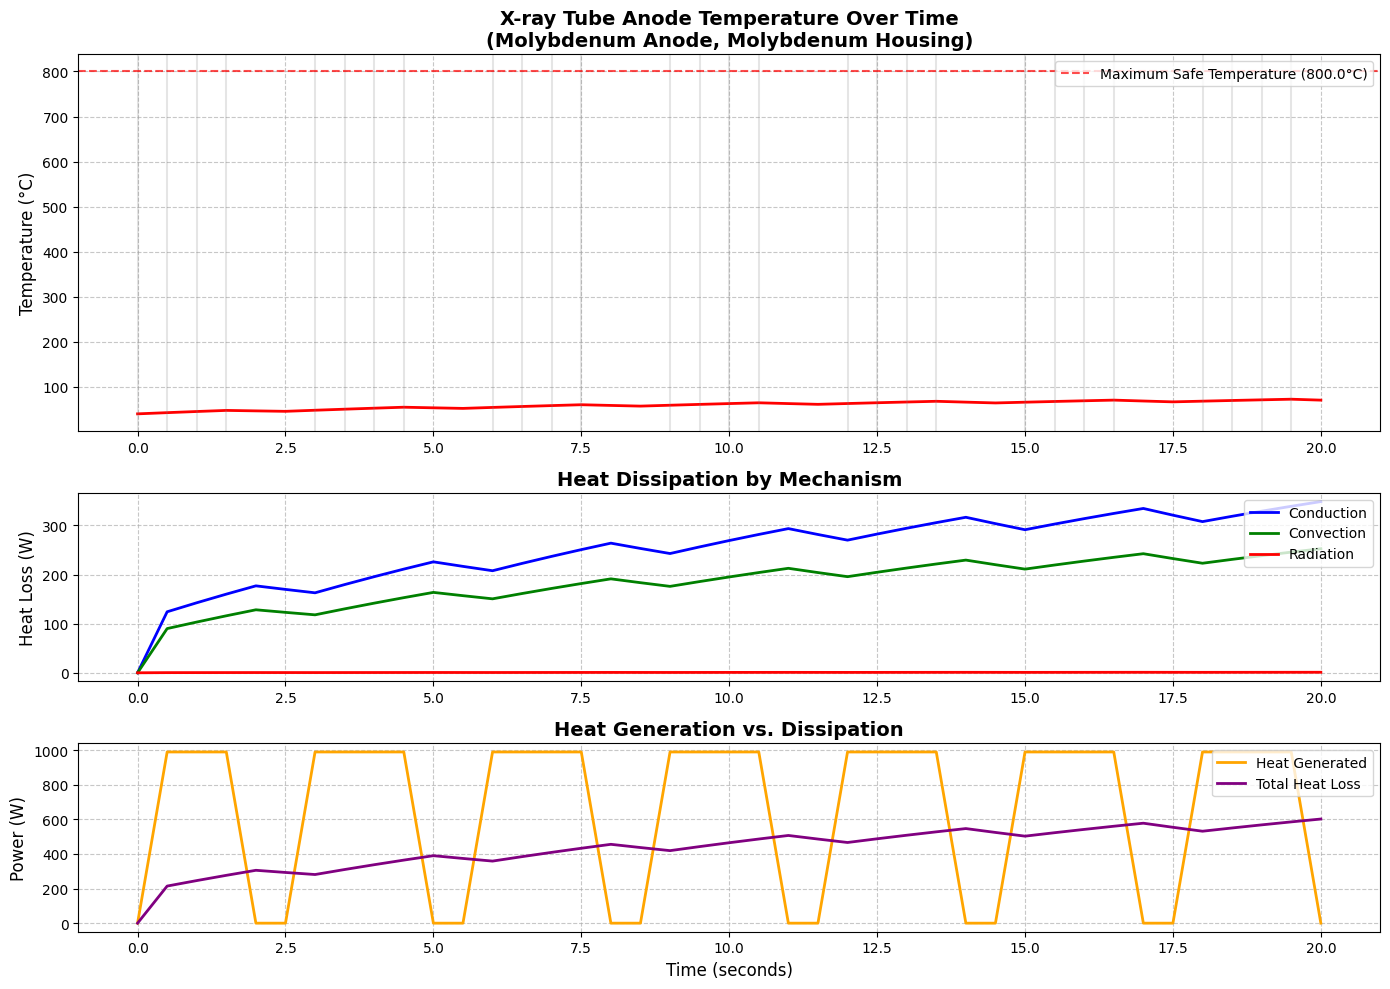

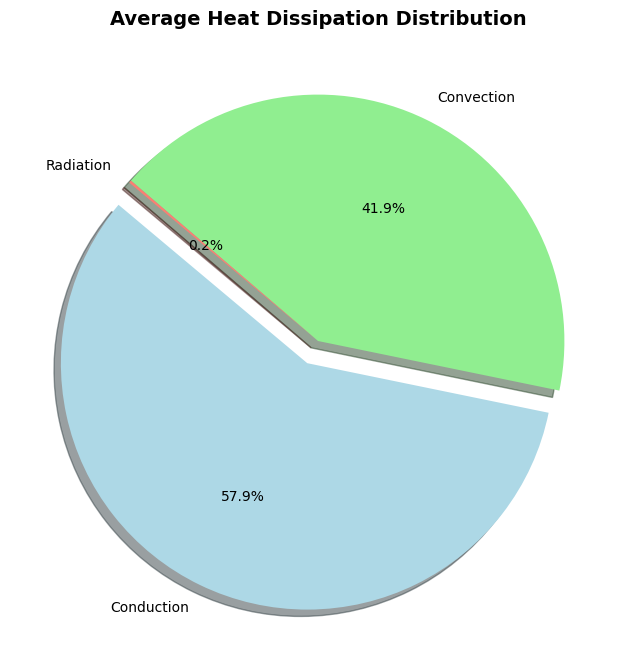


Simulation Results Summary:
Anode Material: Molybdenum
Housing Material: Molybdenum
Maximum Temperature: 72.5°C
Temperature safety margin: 727.5°C

Average heat input during exposure: 990.0 W
Average heat dissipation: 435.2 W


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec

# Define physical constants
STEFAN_BOLTZMANN = 5.67e-8  # Stefan-Boltzmann constant (W/m²K⁴)
AMBIENT_TEMP = 22  # Room temperature (°C)
KELVIN_OFFSET = 273.15  # Offset to convert °C to K

class XRayTubeThermalModel:
    """
    Simulation model for X-ray tube thermal dynamics.
    Models heat generation and dissipation through multiple mechanisms.
    """
    def __init__(self,
                 anode_material="tungsten",
                 anode_diameter=0.12,  # m
                 housing_area=0.2,     # m²
                 tube_housing_material="aluminum",
                 max_safe_temp=1200):  # °C

        # Tube specifications
        self.anode_diameter = anode_diameter
        self.anode_area = np.pi * (anode_diameter/2)**2
        self.housing_area = housing_area

        # Material properties lookup
        self.material_properties = {
            "tungsten": {
                "thermal_conductivity": 173,  # W/m·K
                "specific_heat": 132,         # J/kg·K
                "density": 19300,             # kg/m³
                "emissivity": 0.35
            },
            "aluminum": {
                "thermal_conductivity": 237,  # W/m·K
                "specific_heat": 903,         # J/kg·K
                "density": 2700,              # kg/m³
                "emissivity": 0.09
            },
            "copper": {
                "thermal_conductivity": 401,  # W/m·K
                "specific_heat": 385,         # J/kg·K
                "density": 8960,              # kg/m³
                "emissivity": 0.07
            },
            "molybdenum": {
                "thermal_conductivity": 138,  # W/m·K
                "specific_heat": 251,         # J/kg·K
                "density": 10280,             # kg/m³
                "emissivity": 0.25
            }
        }

        # Apply material properties
        self.anode_material = anode_material
        if anode_material not in self.material_properties:
            raise ValueError(f"Material '{anode_material}' not supported. Available materials: {list(self.material_properties.keys())}")

        self.anode_properties = self.material_properties[anode_material]

        self.housing_material = tube_housing_material
        if tube_housing_material not in self.material_properties:
            raise ValueError(f"Material '{tube_housing_material}' not supported. Available materials: {list(self.material_properties.keys())}")

        self.housing_properties = self.material_properties[tube_housing_material]

        # Heat transfer coefficients
        self.convection_coeff = 25  # W/m²·K (forced convection with cooling)

        # Operating conditions
        self.initial_anode_temp = 40  # °C
        self.max_safe_temp = max_safe_temp     # °C

        # Add temperature alert indicator
        self.temperature_alert = False
        self.alert_message = ""

    def calculate_heat_input(self, kvp, ma, exposure_time):
        """
        Calculate heat generation in an X-ray tube based on exposure parameters.

        Args:
            kvp: Kilovoltage peak (kV)
            ma: Tube current (mA)
            exposure_time: Duration of exposure (s)

        Returns:
            Heat energy generated (J)
        """
        # Standard equation for heat generation in X-ray tubes
        # Typically 99% of electron energy becomes heat
        efficiency_factor = 0.01  # Only ~1% of energy becomes X-rays
        heat_efficiency = 1 - efficiency_factor

        # Convert kV and mA to V and A
        heat_energy = heat_efficiency * (kvp * 1000) * (ma / 1000) * exposure_time
        return heat_energy

    def calculate_conduction_loss(self, temp):
        """Calculate heat loss due to conduction (W)."""
        temp_diff = temp - AMBIENT_TEMP
        # Using thermal conductivity with a geometric factor
        # This is a simplified model; actual conduction paths are complex
        geometric_factor = 0.05  # Simplified path length / area factor
        return self.anode_properties["thermal_conductivity"] * geometric_factor * temp_diff

    def calculate_convection_loss(self, temp):
        """Calculate heat loss due to convection (W)."""
        temp_diff = temp - AMBIENT_TEMP
        return self.convection_coeff * self.housing_area * temp_diff

    def calculate_radiation_loss(self, temp):
        """Calculate heat loss due to radiation (W)."""
        # Convert temperatures to Kelvin
        temp_k = temp + KELVIN_OFFSET
        ambient_k = AMBIENT_TEMP + KELVIN_OFFSET

        # Stefan-Boltzmann law
        return (self.anode_properties["emissivity"] * STEFAN_BOLTZMANN *
                self.anode_area * (temp_k**4 - ambient_k**4))

    def simulate(self, kvp, ma, exposure_time, total_time=300, time_step=1, stop_on_overheat=True):
        """
        Simulate X-ray tube temperature over time with discrete exposures.

        Args:
            kvp: Kilovoltage peak (kV)
            ma: Tube current (mA)
            exposure_time: Duration of each exposure (s)
            total_time: Total simulation time (s)
            time_step: Simulation time step (s)
            stop_on_overheat: Whether to stop simulation if max temp exceeded

        Returns:
            Dictionary containing simulation results
        """
        # Reset alert indicator
        self.temperature_alert = False
        self.alert_message = ""

        # Prepare time array
        time_points = np.arange(0, total_time + time_step, time_step)
        num_steps = len(time_points)

        # Initialize arrays
        temperatures = np.zeros(num_steps)
        temperatures[0] = self.initial_anode_temp

        conduction_losses = np.zeros(num_steps)
        convection_losses = np.zeros(num_steps)
        radiation_losses = np.zeros(num_steps)
        heat_inputs = np.zeros(num_steps)

        # Calculate anode thermal mass
        anode_volume = np.pi * (self.anode_diameter/2)**2 * 0.01  # Assuming 1cm thickness
        anode_mass = anode_volume * self.anode_properties["density"]
        thermal_capacity = anode_mass * self.anode_properties["specific_heat"]

        # Simulate exposure patterns
        # Pattern: exposure_time seconds on, 3 seconds off
        exposure_pattern = []
        exposure_on = True
        current_time = 0

        while current_time < total_time:
            if exposure_on:
                # X-ray is on for exposure_time
                for _ in range(int(exposure_time/time_step)):
                    exposure_pattern.append(1)
                    current_time += time_step
                    if current_time >= total_time:
                        break
                exposure_on = False
            else:
                # Cooling period (3 seconds)
                for _ in range(int(1/time_step)):
                    exposure_pattern.append(0)
                    current_time += time_step
                    if current_time >= total_time:
                        break
                exposure_on = True

        # Extend or trim pattern to match time points
        if len(exposure_pattern) < num_steps:
            exposure_pattern.extend([0] * (num_steps - len(exposure_pattern)))
        else:
            exposure_pattern = exposure_pattern[:num_steps]

        # Run simulation
        for i in range(1, num_steps):
            current_temp = temperatures[i-1]

            # Check for overheating
            if current_temp >= self.max_safe_temp:
                self.temperature_alert = True
                self.alert_message = f"⚠️ Warning: Anode temperature exceeded safe limit of {self.max_safe_temp}°C at t={time_points[i-1]:.1f}s!"
                print(self.alert_message)

                if stop_on_overheat:
                    # Fill remaining arrays with the last value for plotting
                    temperatures[i:] = current_temp
                    time_exceeded = time_points[i-1]
                    return {
                        "time": time_points[:i],
                        "temperature": temperatures[:i],
                        "conduction_loss": conduction_losses[:i],
                        "convection_loss": convection_losses[:i],
                        "radiation_loss": radiation_losses[:i],
                        "heat_input": heat_inputs[:i],
                        "exposure_pattern": exposure_pattern[:i],
                        "temperature_alert": self.temperature_alert,
                        "alert_message": self.alert_message,
                        "time_exceeded": time_exceeded
                    }

            # Calculate heat losses
            conduction_loss = self.calculate_conduction_loss(current_temp)
            convection_loss = self.calculate_convection_loss(current_temp)
            radiation_loss = self.calculate_radiation_loss(current_temp)

            # Record losses
            conduction_losses[i] = conduction_loss
            convection_losses[i] = convection_loss
            radiation_losses[i] = radiation_loss

            # Calculate total heat change
            heat_input = 0
            if exposure_pattern[i] == 1:
                # Heat is being generated during exposure
                heat_input = self.calculate_heat_input(kvp, ma, time_step)
                heat_inputs[i] = heat_input

            total_heat_loss = conduction_loss + convection_loss + radiation_loss
            net_heat = heat_input - total_heat_loss

            # Update temperature based on thermal capacity
            temp_change = net_heat / thermal_capacity
            temperatures[i] = current_temp + temp_change

        return {
            "time": time_points,
            "temperature": temperatures,
            "conduction_loss": conduction_losses,
            "convection_loss": convection_losses,
            "radiation_loss": radiation_losses,
            "heat_input": heat_inputs,
            "exposure_pattern": exposure_pattern,
            "temperature_alert": self.temperature_alert,
            "alert_message": self.alert_message
        }

    def plot_results(self, results):
        """Create professional visualizations of the simulation results."""
        # Create figure with subplots
        fig = plt.figure(figsize=(14, 10))
        gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])

        # Temperature plot
        ax1 = plt.subplot(gs[0])
        ax1.plot(results["time"], results["temperature"], 'r-', linewidth=2)
        ax1.set_ylabel('Temperature (°C)', fontsize=12)

        # Set title with material information
        title = f'X-ray Tube Anode Temperature Over Time\n({self.anode_material.capitalize()} Anode, {self.housing_material.capitalize()} Housing)'
        ax1.set_title(title, fontsize=14, fontweight='bold')
        ax1.grid(True, linestyle='--', alpha=0.7)

        # Add exposure indicators
        exposure_times = np.where(np.array(results["exposure_pattern"]) == 1)[0]
        for exp_time in exposure_times:
            if exp_time < len(results["time"]):
                ax1.axvline(x=results["time"][exp_time], color='gray', alpha=0.2)

        # Add maximum safe temperature line
        ax1.axhline(y=self.max_safe_temp, color='r', linestyle='--', alpha=0.7,
                    label=f'Maximum Safe Temperature ({self.max_safe_temp}°C)')

        # Add temperature alert annotation if needed
        if results.get("temperature_alert", False):
            if "time_exceeded" in results:
                ax1.annotate(f'Temperature Limit Exceeded!\n{self.max_safe_temp}°C at t={results["time_exceeded"]:.1f}s',
                            xy=(results["time_exceeded"], self.max_safe_temp),
                            xytext=(results["time_exceeded"]+10, self.max_safe_temp-100),
                            arrowprops=dict(facecolor='red', shrink=0.05),
                            bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.8))

        ax1.legend(loc='upper right')

        # Heat loss breakdown
        ax2 = plt.subplot(gs[1], sharex=ax1)
        ax2.plot(results["time"], results["conduction_loss"], 'b-',
                 label='Conduction', linewidth=2)
        ax2.plot(results["time"], results["convection_loss"], 'g-',
                 label='Convection', linewidth=2)
        ax2.plot(results["time"], results["radiation_loss"], 'r-',
                 label='Radiation', linewidth=2)
        ax2.set_ylabel('Heat Loss (W)', fontsize=12)
        ax2.set_title('Heat Dissipation by Mechanism', fontsize=14, fontweight='bold')
        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.legend(loc='upper right')

        # Heat input and total heat balance
        ax3 = plt.subplot(gs[2], sharex=ax1)
        total_loss = (results["conduction_loss"] +
                      results["convection_loss"] +
                      results["radiation_loss"])
        ax3.plot(results["time"], results["heat_input"], 'orange',
                 label='Heat Generated', linewidth=2)
        ax3.plot(results["time"], total_loss, 'purple',
                 label='Total Heat Loss', linewidth=2)
        ax3.set_xlabel('Time (seconds)', fontsize=12)
        ax3.set_ylabel('Power (W)', fontsize=12)
        ax3.set_title('Heat Generation vs. Dissipation', fontsize=14, fontweight='bold')
        ax3.grid(True, linestyle='--', alpha=0.7)
        ax3.legend(loc='upper right')

        # Adjust layout
        plt.tight_layout()

        # Create a separate figure for pie chart of average heat dissipation
        fig2, ax4 = plt.subplots(figsize=(8, 8))

        # Calculate average heat losses (excluding zero values)
        avg_conduction = np.mean(results["conduction_loss"][results["conduction_loss"] > 0])
        avg_convection = np.mean(results["convection_loss"][results["convection_loss"] > 0])
        avg_radiation = np.mean(results["radiation_loss"][results["radiation_loss"] > 0])

        # Create pie chart
        labels = ['Conduction', 'Convection', 'Radiation']
        sizes = [avg_conduction, avg_convection, avg_radiation]
        colors = ['lightblue', 'lightgreen', 'salmon']
        explode = (0.1, 0, 0)  # explode conduction slice

        ax4.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                shadow=True, startangle=140)
        ax4.set_title('Average Heat Dissipation Distribution', fontsize=14, fontweight='bold')

        plt.show()

        return fig, fig2

def run_interactive_simulation():
    """Run an interactive simulation with user inputs"""
    print("X-ray Tube Thermal Simulation")
    print("============================")

    # Get material input
    print("\nAvailable materials:")
    materials = ["tungsten",  "copper", "molybdenum"]
    for i, material in enumerate(materials, 1):
        print(f"{i}. {material.capitalize()}")

    while True:
        try:
            anode_choice = int(input("\nSelect anode material (1-3): "))
            if 1 <= anode_choice <= 4:
                anode_material = materials[anode_choice-1]
                break
            else:
                print("Invalid choice. Please enter a number between 1 and 4.")
        except ValueError:
            print("Please enter a valid number.")

    while True:
        try:
            housing_choice = int(input("Select housing material (1-3): "))
            if 1 <= housing_choice <= 4:
                housing_material = materials[housing_choice-1]
                break
            else:
                print("Invalid choice. Please enter a number between 1 and 4.")
        except ValueError:
            print("Please enter a valid number.")

    # Get X-ray parameters
    while True:
        try:
            kvp = float(input("\nEnter tube voltage (kVp, 40-150): "))
            if 40 <= kvp <= 150:
                break
            else:
                print("Please enter a value between 40 and 150 kVp.")
        except ValueError:
            print("Please enter a valid number.")

    while True:
        try:
            ma = float(input("Enter tube current (mA, 50-600): "))
            if 50 <= ma <= 600:
                break
            else:
                print("Please enter a value between 50 and 600 mA.")
        except ValueError:
            print("Please enter a valid number.")

    while True:
        try:
            exposure_time = float(input("Enter exposure time (seconds, 0.1-5): "))
            if 0.1 <= exposure_time <= 5:
                break
            else:
                print("Please enter a value between 0.1 and 5 seconds.")
        except ValueError:
            print("Please enter a valid number.")

    while True:
        try:
            max_temp = float(input("Enter maximum safe temperature (°C, 800-1500): "))
            if 800 <= max_temp <= 1500:
                break
            else:
                print("Please enter a value between 800 and 1500 °C.")
        except ValueError:
            print("Please enter a valid number.")

    # Create model with user parameters
    model = XRayTubeThermalModel(
        anode_material=anode_material,
        tube_housing_material=housing_material,
        max_safe_temp=max_temp
    )

    # Run simulation
    results = model.simulate(
        kvp=kvp,
        ma=ma,
        exposure_time=exposure_time,
        total_time=20,
        time_step=0.5,
        stop_on_overheat=True
    )

    # Plot results
    model.plot_results(results)

    # Display summary
    print("\nSimulation Results Summary:")
    print("===========================")
    print(f"Anode Material: {anode_material.capitalize()}")
    print(f"Housing Material: {housing_material.capitalize()}")
    print(f"Maximum Temperature: {max(results['temperature']):.1f}°C")

    if results.get("temperature_alert", False):
        print(f"\n{results.get('alert_message', 'Temperature exceeded safe limits!')}")
    else:
        margin = max_temp - max(results['temperature'])
        print(f"Temperature safety margin: {margin:.1f}°C")

    # Calculate cooling efficiency
    avg_heat_in = np.mean(results["heat_input"][results["heat_input"] > 0])
    avg_heat_loss = np.mean(results["conduction_loss"] + results["convection_loss"] + results["radiation_loss"])

    print(f"\nAverage heat input during exposure: {avg_heat_in:.1f} W")
    print(f"Average heat dissipation: {avg_heat_loss:.1f} W")

    return model, results

# Example of running the interactive simulation
if __name__ == "__main__":
    # Run interactive mode (comment out for direct import)
    model, results = run_interactive_simulation()
\
    # Or run with predefined parameters
    '''
    model = XRayTubeThermalModel(
        anode_material="tungsten",
        tube_housing_material="copper"
    )

    results = model.simulate(
        kvp=120,      # 120 kV
        ma=250,       # 250 mA
        exposure_time=0.5,  # 0.5 second exposure
        total_time=200,     # 200 seconds of simulation
        time_step=0.5       # 0.5 second time steps
    )

    model.plot_results(results)
    '''

In [4]:
 !pip install gradio
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Physical constants
STEFAN_BOLTZMANN = 5.67e-8  # Stefan-Boltzmann constant (W/m²K⁴)
AMBIENT_TEMP = 22  # Room temperature (°C)
KELVIN_OFFSET = 273.15  # Offset to convert °C to K

def simulate_xray_tube(anode_material, housing_material, voltage, current, exposure_time, max_temp):
    """
    Simulate X-ray tube thermal behavior with more realistic calculations
    """
    # Material properties dictionary
    material_properties = {
        "Tungsten": {
            "thermal_conductivity": 173,  # W/m·K
            "specific_heat": 132,         # J/kg·K
            "density": 19300,             # kg/m³
            "emissivity": 0.35
        },
        "Aluminum": {
            "thermal_conductivity": 237,  # W/m·K
            "specific_heat": 903,         # J/kg·K
            "density": 2700,              # kg/m³
            "emissivity": 0.09
        },
        "Copper": {
            "thermal_conductivity": 401,  # W/m·K
            "specific_heat": 385,         # J/kg·K
            "density": 8960,              # kg/m³
            "emissivity": 0.07
        },
        "Molybdenum": {
            "thermal_conductivity": 138,  # W/m·K
            "specific_heat": 251,         # J/kg·K
            "density": 10280,             # kg/m³
            "emissivity": 0.25
        }
    }

    materials = list(material_properties.keys())
    anode = materials[anode_material - 1]
    housing = materials[housing_material - 1]

    # Realistic heat generation calculation
    efficiency_factor = 0.01  # Only ~1% of energy becomes X-rays
    heat_input = (voltage * 1000) * (current / 1000) * exposure_time * (1 - efficiency_factor)

    # Thermal properties of the selected materials
    anode_props = material_properties[anode]
    housing_props = material_properties[housing]

    # Simplified thermal simulation
    time = np.linspace(0, 200, 200)

    # Calculate thermal mass and heat capacity
    anode_volume = np.pi * (0.12/2)**2 * 0.01  # Assuming 1cm thickness
    anode_mass = anode_volume * anode_props["density"]
    thermal_capacity = anode_mass * anode_props["specific_heat"]

    # Convection and radiation heat loss
    convection_coeff = 25  # W/m²·K
    housing_area = 0.2  # m²

    # Temperature calculation with simplified heat transfer model
    def calculate_temperature(t):
        # Sinusoidal exposure pattern (on/off)
        exposure_pattern = np.sin(t / 20) > 0

        # Simplified heat transfer model
        if exposure_pattern:
            # During exposure
            temp_rise = heat_input / thermal_capacity
            temp = 40 + temp_rise * (t / 10)
        else:
            # Cooling phase
            # Calculate heat losses
            current_temp = 40 + heat_input / thermal_capacity * (t / 10)

            # Radiation loss
            current_temp_k = current_temp + KELVIN_OFFSET
            radiation_loss = (anode_props["emissivity"] * STEFAN_BOLTZMANN *
                              housing_area * (current_temp_k**4 - (AMBIENT_TEMP + KELVIN_OFFSET)**4))

            # Convection loss
            convection_loss = convection_coeff * housing_area * (current_temp - AMBIENT_TEMP)

            # Temperature decrease
            temp_decrease = (radiation_loss + convection_loss) / thermal_capacity
            temp = max(current_temp - temp_decrease, AMBIENT_TEMP)

        return min(temp, max_temp)

    # Calculate temperatures
    temperature = np.vectorize(calculate_temperature)(time)

    # Create temperature plot
    temp_fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(time, temperature, color='red', label='Anode Temperature')
    ax.axhline(max_temp, color='orange', linestyle='--', label=f'Max Safe Temperature ({max_temp}°C)')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title(f"X-ray Tube Anode Temperature\n({anode} Anode, {housing} Housing)")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()

    # Create heat dissipation pie chart
    heat_fig, ax = plt.subplots(figsize=(8, 8))

    # Estimating heat dissipation mechanisms
    radiation_loss = anode_props["emissivity"] * STEFAN_BOLTZMANN * housing_area
    convection_loss = convection_coeff * housing_area
    conduction_loss = anode_props["thermal_conductivity"] * 0.05  # Simplified

    labels = ['Radiation', 'Convection', 'Conduction']
    sizes = [radiation_loss, convection_loss, conduction_loss]
    colors = ['salmon', 'lightgreen', 'lightblue']

    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.set_title('Heat Dissipation Distribution')

    # Prepare summary
    max_temp_reached = np.max(temperature)
    safety_margin = max_temp - max_temp_reached

    summary = f"""🔬 X-ray Tube Thermal Simulation Results 🔬

📍 Configuration:
   • Anode Material: {anode}
   • Housing Material: {housing}
   • Tube Voltage: {voltage} kVp
   • Tube Current: {current} mA
   • Exposure Time: {exposure_time} s

🌡️ Temperature Analysis:
   • Peak Temperature: {max_temp_reached:.1f}°C
   • Max Safe Temperature: {max_temp}°C
   • Temperature Safety Margin: {safety_margin:.1f}°C

📊 Heat Transfer:
   • Total Heat Input: {heat_input:.1f} W
   • Estimated Radiation Loss: {radiation_loss:.1f} W
   • Estimated Convection Loss: {convection_loss:.1f} W
   • Estimated Conduction Loss: {conduction_loss:.1f} W
"""

    return summary, temp_fig, heat_fig

# Create the Gradio interface
interface = gr.Interface(
    fn=simulate_xray_tube,
    inputs=[
        gr.Dropdown([1, 2, 3], label="Select Anode Material (1-4)",
                    info="1: Tungsten,  2: Copper, 3: Molybdenum"),
        gr.Dropdown([1,2, 3], label="Select Housing Material (1-4)",
                    info="1: Tungsten, 2: Copper, 3: Molybdenum"),
        gr.Slider(40, 150, value=120, label="Tube Voltage (kVp)"),
        gr.Slider(50, 600, value=250, label="Tube Current (mA)"),
        gr.Slider(0.1, 5, value=0.5, label="Exposure Time (seconds)"),
        gr.Slider(800, 1500, value=1200, label="Max Safe Temperature (°C)"),
    ],
    outputs=[
        gr.Textbox(label="Simulation Results Summary"),
        gr.Plot(label="Temperature Over Time"),  # Use gr.Plot for Matplotlib figures
        gr.Plot(label="Heat Dissipation Distribution")  # Use gr.Plot for Matplotlib figures
    ],
    title="X-ray Tube Thermal Simulation",
    description="Simulate the thermal behavior of an X-ray tube based on input parameters.",
)

# Launch the interface
interface.launch()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.0 MB/s eta 0:00:00
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://62614cd8933d750cff.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/s